In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from google.colab import drive

## Dataset

In [2]:
drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/MyDrive/Final Project/Dataset/Aloevera/'

Mounted at /content/gdrive


In [3]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64 

In [4]:
train_datagen = ImageDataGenerator(rescale = 1/255, 
                                   validation_split = .2)

train_batches = train_datagen.flow_from_directory(
    path,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    shuffle = True, seed = 666
)

val_batches = train_datagen.flow_from_directory(
    path,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    shuffle = True, seed = 666
)

Found 2797 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [5]:
labels = train_batches.class_indices
classes_num = len(train_batches.class_indices)

In [6]:
labels

{'Aloevera_healthy': 0, 'Aloevera_rot': 1, 'Aloevera_rust': 2}

In [7]:
import matplotlib.pyplot as plt

def plotimg(images):
  fig, axes = plt.subplots(1, 5, figsize=(40, 40))
  for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.show()

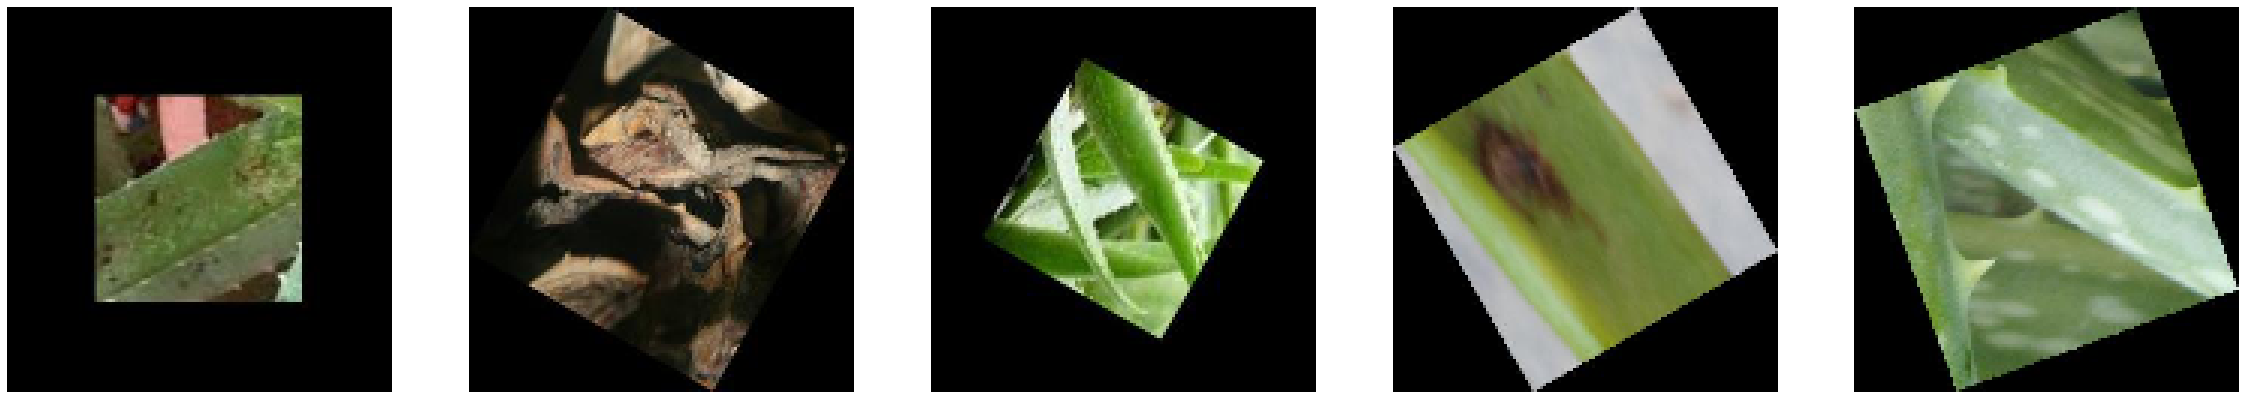

In [8]:
imgs, labels = train_batches[0]
plotimg(imgs)
print(labels[:5])

## Model

In [7]:
# Import MobileNetV2 as pre trained model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pretrained_model = MobileNetV2(input_shape=(128, 128, 3),
                               include_top=False,
                              )
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [14]:
# Take last layer
last_layer = pretrained_model.get_layer('block_1_pad')
last_output = last_layer.output

In [16]:
from tensorflow.keras import layers, Model

# Add a convolution layer with 32 filters
x = layers.Conv2D(32, (3,3), activation='relu')(last_output)
# Add a 2x2 pooling layer
x = layers.MaxPooling2D(2,2)(x)
# Add a convolution layer with 16 filters
x = layers.Conv2D(16, (3,3), activation='relu')(x)
# Add a 2x2 pooling layer
x = layers.MaxPooling2D(2,2)(x)
# Add a convolution layer with 8 filters
x = layers.Conv2D(8, (3,3), activation='relu')(x)
# Add a 2x2 pooling layer
x = layers.MaxPooling2D(2,2)(x)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a fully connected layer with 128 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a final softmax layer for classification
x = layers.Dense(classes_num, activation='softmax')(x)           
# Append the dense network to the base model
model = Model(pretrained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 bn_Conv1 (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 Conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 expanded_conv_depthwise (De  (None, 64, 64, 32)       288       
 pthwiseConv2D)                                                  
                                                                 
 expanded_conv_depthwise_BN   (None, 64, 64, 32)       128   

In [7]:
model_aloevera = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu',),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(classes_num, activation='softmax')
])    

model_aloevera.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 8)        0

In [18]:
# Compile the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=1e-4), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

## Train & Evaluate

In [20]:
# Train the model
history = model.fit(
            x = train_batches,
            validation_data = val_batches,
            epochs = 20,
            verbose = 1,
            # validation_steps = 5,
            # steps_per_epoch = 16,
            )

Epoch 1/20
44/44 [==============================] - 13s 301ms/step - loss: 0.3127 - accuracy: 0.8670 - val_loss: 0.3970 - val_accuracy: 0.8095
Epoch 2/20
44/44 [==============================] - 10s 230ms/step - loss: 0.3108 - accuracy: 0.8659
Epoch 3/20
44/44 [==============================] - 10s 223ms/step - loss: 0.3025 - accuracy: 0.8699
Epoch 4/20
44/44 [==============================] - 10s 229ms/step - loss: 0.2886 - accuracy: 0.8774
Epoch 5/20
44/44 [==============================] - 10s 227ms/step - loss: 0.2949 - accuracy: 0.8706
Epoch 6/20
44/44 [==============================] - 10s 227ms/step - loss: 0.2875 - accuracy: 0.8763
Epoch 7/20
44/44 [==============================] - 10s 226ms/step - loss: 0.2657 - accuracy: 0.8867
Epoch 8/20
44/44 [==============================] - 10s 225ms/step - loss: 0.2738 - accuracy: 0.8820
Epoch 9/20
44/44 [==============================] - 10s 227ms/step - loss: 0.2643 - accuracy: 0.8856
Epoch 10/20
44/44 [==============================

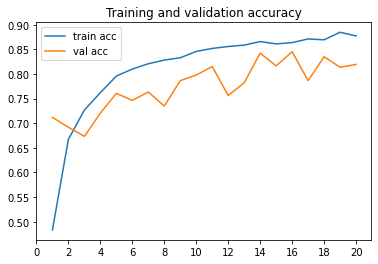

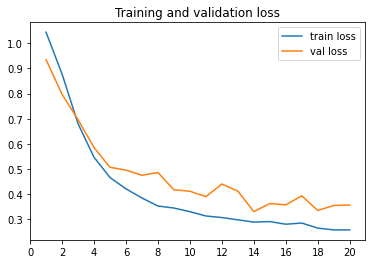

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve history as lists
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='train acc')
plt.plot(epochs, val_acc, label='val acc')
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc)+1, 2))
plt.legend(['train acc', 'val acc'])
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Training and validation loss')
plt.legend(['train loss', 'val loss'])
plt.xticks(np.arange(0, len(acc)+1, 2))
plt.show()

In [33]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_aloevera.predict(images, batch_size=64)
  print(fn)
  print(list(labels)[np.argmax(classes[0])])
  # print(classes[0])

Saving Aloe-Vera.jpg to Aloe-Vera.jpg
Aloe-Vera.jpg
Aloevera_healthy


In [ ]:
list(labels)[np.argmax(classes[0])]

'Apple_cedar_rust'

## Save & Convert Model

In [36]:
# save model
model_aloevera.save('/content/model/planticure_model_aloevera.h5')

In [38]:
tf.saved_model.save(model_aloevera, '/content/model/')

INFO:tensorflow:Assets written to: /content/model/assets


In [39]:
# Convert model to tflite
tflite_model = tf.lite.TFLiteConverter.from_saved_model('/content/model/').convert()

In [40]:
# Save tflite model
import pathlib

pathlib.Path('/content/model/planticure_model_aloevera.tflite').write_bytes(tflite_model)

2801376

In [41]:
# Save labels
with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

#### Quantization

In [43]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

In [44]:
import pathlib

pathlib.Path('/content/model/planticure_quantized_model_aloevera.tflite').write_bytes(tflite_quantized_model)

708256

In [42]:
try:
    from google.colab import files
    files.download('/content/model/planticure_model_aloevera.tflite')
    #files.download('/content/model/planticure_quantized_model.tflite')
    files.download('/content/model/planticure_model_aloevera.h5')
    #files.download('/content/saved_model.pb')
    files.download('/content/labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
files.download('/content/model/planticure_quantized_model_aloevera.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>